#Reinforcement Learning project: The Blackjack dream.



by Santiago Licea

In [ ]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import gym
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import contextlib
import os
from tqdm import tqdm
from sklearn.utils import shuffle

##Basic strategy evaluation.

Let's first create our Blackjack class. We will use it to simulate a blackjack round/game with a dealer and a single player that follows the basic strategy. The idea is to simulate many rounds to analyze the player's chances.

In [ ]:
###meter más jugadores para que el agente pueda decidir cuando salirse?

In [ ]:
class BlackjackBS():
  def __init__(self, bjRatio=(3/2), playersMoney=100, minBet=10, nDecks=6, hitsSoft17=True, doubleAfterSplit=True):
    '''
    bjRatio: the ratio that the house pays when the player gets a blackjack AND the dealer doesn't. If 3 to 2, then the house pays 1.5 the bet.
    playersMoney: the total money on the player's wallet.
    minBet: the minimum bet requiered to enter the table, we asume that the player will always bet this amount.
    nDecks: number of decks to be used.
    hitsSoft17: True or False depending whether the dealer hits on Ace and 6 or doesn't.
    doubleAfterSplit: indicates whether the player can double down after splitting.
      Observations:
    Basic strategy obtained from https://www.techopedia.com/gambling-guides/blackjack-strategy
    We won't allow the player to surrender since most casinos don't have this variant.
    We won't consider insurance (according to the basic strategy the player most never buy it anyways).
    For the coding we won't consider the card suits since they don't matter in this game.
    The player will only get one more card if he doubles down.
    We asume that the player will always have money for splitting or doubling down (meaning he can have negative earnings).
    '''
    self.bjRatio = bjRatio
    self.playersMoney = playersMoney
    self.minBet = minBet
    self.nDecks = nDecks
    self.hitsSoft17 = hitsSoft17
    self.doubleAfterSplit = doubleAfterSplit
    self.values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] #11 will be treated as an ace
    self.whichDeck = 'original' #'original' indicates the original deck, 'remainder' for when the shuffled remainder of the deck is being used
    #to continue the hand in case the original deck is empty in the middle of a round.
    self.wins = defaultdict(int) #dictonary containing the count for wins for 'player' and 'dealer' and the amount of 'pushes'
    self.shuffle()
    self.remainder = [] #contains the cards played after each round.
    self.dealer = [] #dealer's hand
    self.player = [[]] #player's hand, a list of lists (since he can have multiple hands after splitting)
    self.doubledDown = [False] #boolean values indicating whether a hand has been doubled down
    self.numSplits = 0 #to later obtain the total number of hands played

  def shuffle(self):
    if self.whichDeck=='original':
      self.deck = [value for value in self.values for i in range(4)] * self.nDecks
      random.shuffle(self.deck)
      self.remainder = []
    elif self.whichDeck=='remainder':
      random.shuffle(self.remainder)
      self.deck = self.remainder.copy()
      self.remainder = []

  def checkCardsLeft(self):
    '''
    In case there are no more cards left in the deck, it shuffles and uses the remaining cards to finish the hand.
    It is called when someone wishes to hit.
    '''
    if len(self.deck) == 0: #no more cards left
      self.whichDeck = 'remainder'
      self.shuffle()
    else:
      return

  def hit(self, who, index=0):
    '''
    who: 'dealer' or 'player'.
    index: the index of the hand that the player wants to hit (in case he splitted).
    '''
    self.checkCardsLeft()
    if who=='dealer':
      self.dealer.append(self.deck.pop())
    elif who=='player':
      self.player[index].append(self.deck.pop())

  def dealersTurn(self):
    '''
    Hits until the sum is more or equal to 17. Handles special case of soft 17 and of aces valued as 11 needing to change to 1.
    '''
    while sum(self.dealer) < 17:
      self.hit('dealer')
      if sum(self.dealer) > 21 and 11 in self.dealer:
        ind = self.dealer.index(11)
        self.dealer[ind] = 1
      if sum(self.dealer) == 17 and 11 in self.dealer and self.hitsSoft17: #soft 17
        self.hit('dealer')
        if sum(self.dealer) > 21:
          ind = self.dealer.index(11)
          self.dealer[ind] = 1

  def win(self, blackjack=False, doubledDown=False):
    self.wins['player'] += 1
    if blackjack:
      self.playersMoney += self.minBet + self.bjRatio*self.minBet
    else:
      if not doubledDown:
        self.playersMoney += 2*self.minBet
      else:
        self.playersMoney += 4*self.minBet

  def loss(self):
    self.wins['dealer'] += 1

  def push(self):
    self.wins['pushes'] += 1
    self.playersMoney += self.minBet

  def split(self, index):
    '''
    Obtains the index of the hand the player wishes to split (in case he already has more than one hand).
    Returns the splited hand, for example [[4, 5], [2, 2]] returns [[4, 5], [2], [2]] for index=1
    '''
    self.playersMoney -= self.minBet
    splitted = []
    for i, hand in enumerate(self.player):
      if i == index:
        splitted.extend([[item] for item in hand])
      else:
        splitted.append(hand)
    self.player = splitted
    self.doubledDown[index:index+1] = [False, False]

  def simulation(self, n):
    '''
    n: number of rounds to simulate.
    We created this function since we can't include a for loop in round() because we call it recursively in
    case of a split.
    '''
    for _ in range(n):
      self.round()

  def round(self):
    '''
    Conducts a single round of blackjack, from when the player places his bet to when the round finishes and
    the player is handed money or not.
    '''
    #dealer hands cards:
    if self.player==[[]]: #this means the function hasn't been called recursively after a split
      self.playersMoney -= self.minBet
      self.hit('player', 0)
      self.hit('dealer')
      self.hit('player', 0)
      self.hit('dealer')
    else: #the dealer gives a card to each hand after a split
      for index, hand in enumerate(self.player):
        if len(hand) == 1:
          self.hit('player', index)

    #player's decisions:
    for index, hand in enumerate(self.player):
      #win or loose will be determined after the for loop

      #player gets a hand where he must split
      if hand[0] == hand[1] and len(hand)==2: #pair
        def func(p, a, b):
          return hand[0]==p and self.dealer[-1] in range(a, b+1)
        if self.doubleAfterSplit:
          if hand[0]==11 or hand[0]==8 or func(2,2,7) or func(3,2,7) or func(4,5,6) or func(6,2,6) or func(7,2,7) or func(9,2,6) or func(9,8,9):
            #split:
            self.split(index)
            self.round()
            return
        else:
          if hand[0]==11 or hand[0]==8 or func(2,4,7) or func(3,4,7) or func(6,3,6) or func(7,2,7) or func(9,2,6) or func(9,8,9):
            #split:
            self.split(index)
            self.round()
            return

      #player gets a blackjack or a hand where he must stand
      #blackjack = hand[0]+hand[1]==21
      twentyOne = sum(hand)==21
      cond1 = hand[0]==hand[1]==10
      cond2 = hand[0]==hand[1]==9 and self.dealer[-1] in (7,10,11) and len(hand)==2
      if 11 in hand:
        indx11 = hand.index(11)
        cond3 = sum(hand[:indx11] + hand[indx11+1:])==8
        cond4 = sum(hand[:indx11] + hand[indx11+1:])==7 and self.dealer[-1] in (2,7,8)
        cond8 = sum(hand[:indx11] + hand[indx11+1:])==7 and self.dealer[-1] in range(3, 7) and len(hand)>2
      else:
        cond3 = False
        cond4 = False
        cond8 = False
      cond5 = sum(hand)==17 and 11 not in hand
      cond6 = sum(hand)==12 and 11 not in hand and self.dealer[-1] in (4,5,6)
      cond7 = sum(hand) in range(13, 17) and 11 not in hand and self.dealer[-1] in range(2, 7)
      if twentyOne or cond1 or cond2 or cond3 or cond4 or cond5 or cond6 or cond7 or cond8:
        #stand:
        continue

      #Se usan en los ifs de abajo:
      def func1(s, a, b):
        return sum(hand)==s and self.dealer[-1] in range(a, b+1) and 11 not in hand
      def func2(p, a, b):
        if 11 in hand:
          indx11 = hand.index(11)
          return sum(hand[:indx11] + hand[indx11+1:])==p and self.dealer[-1] in range(a, b+1)
        else:
          return False
      def func3(p, a, b):
        return len(hand)==2 and hand[0]==hand[1]==p and self.dealer[-1] in range(a, b+1)

      #player gets a sum straight away (without hitting) where he must double down
      if len(hand)==2:
        if func1(9,3,6) or func1(10,2,9) or sum(hand)==11 or func2(2,5,6) or func2(3,5,6) or func2(4,4,6) or func2(5,4,6) or func2(6,3,6) or func2(7,3,6) or func3(5,2,9):
          if self.doubleAfterSplit or (not self.doubleAfterSplit and len(self.player)==1):               ###!! added
            #double down:
            self.playersMoney -= self.minBet               ###!! must be paid 4 times initial bet then
            self.hit('player', index)
            self.doubledDown[index] = True
            continue
          elif not self.doubleAfterSplit and len(self.player)>1:
            #hit
            self.hit('player', index)
            self.round()
            return

      elif len(hand)>2: #after hitting
        if func1(9,3,6) or func1(10,2,9) or sum(hand)==11 or func2(2,5,6) or func2(3,5,6) or func2(4,4,6) or func2(5,4,6) or func2(6,3,6):
          if not self.doubledDown[index]:
            #hit:
            self.hit('player', index)
            self.round()
            return
          else:
            continue

      #player has a hand where he must hit
      cond1 = sum(hand)<=8 or func1(9,2,2) or func1(9,7,11) or func1(10,10,11) or func1(12,2,3)
      cond2 = any([func1(i,7,11) for i in range(12, 17)])
      cond3 = func2(2,2,4) or func2(3,2,4) or func2(4,2,3) or func2(5,2,3) or func2(6,2,2) or func2(7,9,11)
      cond4 = any([func2(i,7,11) for i in range(2, 7)])
      if self.doubleAfterSplit:
        cond5 = func3(2,8,11) or func3(3,8,11) or func3(4,2,4) or func3(4,7,11) or func3(5,10,11) or func3(6,7,11) or func3(7,8,11)       #
      else:
         cond5 = func3(2,2,3) or func3(2,8,11) or func3(3,2,3) or func3(3,8,11) or func3(4,2,11) or func3(5,10,11) or func3(6,2,2) or func3(6,7,11) or func3(7,8,11)
      if cond1 or cond2 or cond3 or cond4 or cond5:
        if not self.doubledDown[index]:
          #hit:
          self.hit('player', index)
          self.round()
          return
        else:
          continue

        ind = self.dealer.index(11)
        self.dealer[ind] = 1

      #player has more than 21
      if sum(hand)>21:
        if 11 in hand:
          #we replace the first 11 with a 1
          ind = hand.index(11)
          hand[ind] = 1
          self.player[index] = hand
          self.round()
          return
      else:
        continue

    #End of round, now comes the dealer's turn and discover who won
    self.dealersTurn()

    for index, hand in enumerate(self.player):
      if hand[0]+hand[1]==21 and self.dealer[0]+self.dealer[1]!=21:
        self.win(blackjack=True) #blackjack
      elif hand[0]+hand[1]==21 and self.dealer[0]+self.dealer[1]==21:
        self.push()
      elif self.dealer[0]+self.dealer[1]==21:
        self.loss()
      elif sum(hand)>21:
        self.loss()
      elif sum(hand)==21:
        if sum(self.dealer)==21:
          self.push()
        else:
          if self.doubledDown[index]:
            self.win(blackjack=False, doubledDown=True)
          else:
            self.win(blackjack=False, doubledDown=False)
      elif sum(self.dealer)==sum(hand):
        self.push()
      elif sum(hand)>sum(self.dealer):
        if self.doubledDown[index]:
          self.win(blackjack=False, doubledDown=True)
        else:
          self.win(blackjack=False, doubledDown=False)
      elif sum(hand)<sum(self.dealer):
        if sum(self.dealer)>21:
          if self.doubledDown[index]:
            self.win(blackjack=False, doubledDown=True)
          else:
            self.win(blackjack=False, doubledDown=False)
        else:
          self.loss()

    #Finally we check if we used the original or remainder deck in this round:
    if self.whichDeck=='remainder':
      #we shuffle all the cards and set the remainder deck to an empty list
      self.whichDeck = 'original'
      self.shuffle()
    elif self.whichDeck=='original':
      #we add the played cards to the remainder deck
      self.remainder.extend(self.dealer)
      self.remainder.extend(item for sublist in self.player for item in sublist)

    self.numSplits += len(self.player)-1
    #we empty the hands
    self.dealer = []
    self.player = [[]]
    self.doubledDown = [False]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's now simulate a million rounds to see the overall number of wins, losses, and pushes/ties.

In [ ]:
n = 1000000
bj = BlackjackBS()
bj.simulation(n)

handsPlayed = n + bj.numSplits

print('\t1,000,000 blackjack hands simulation playing a perfect basic strategy\n')
print(f'Player\'s money: {bj.playersMoney}')
print(f'Results dictionary: {bj.wins}')
print('\n')
print(f'Win percentage: {(bj.wins["player"]/handsPlayed)*100:.2f}%')
print(f'Loss percentage: {(bj.wins["dealer"]/handsPlayed)*100:.2f}%')
print(f'Push percentage: {(bj.wins["pushes"]/handsPlayed)*100:.2f}%')

	1,000,000 blackjack hands simulation playing a perfect basic strategy

Player's money: -355150.0
Results dictionary: defaultdict(<class 'int'>, {'player': 443618, 'pushes': 86721, 'dealer': 498957})


Win percentage: 43.10%
Loss percentage: 48.48%
Push percentage: 8.43%


Now let's simulate for several number of rounds to look at the distribution of the player's earnings.

In [ ]:
def montecarlo(rounds=[30], n=10000):
  '''
  Obtains several graphs for the distribution of the earnings for different number of rounds.
  '''
  plt.figure(figsize=(10, 7))
  plt.title('Earnings after different number of rounds')
  plt.xlabel('$')
  for i in rounds:
    arr = []
    for _ in range(n):
      bj = BlackjackBS()
      bj.simulation(i)
      arr.append(bj.playersMoney)
    sns.kdeplot(arr, label=f'{i} rounds, mean: {np.mean(arr):.2f}, std: {np.std(arr):.2f}');
  plt.axvline(100, color='black', linestyle='--', label='$100')
  plt.legend()

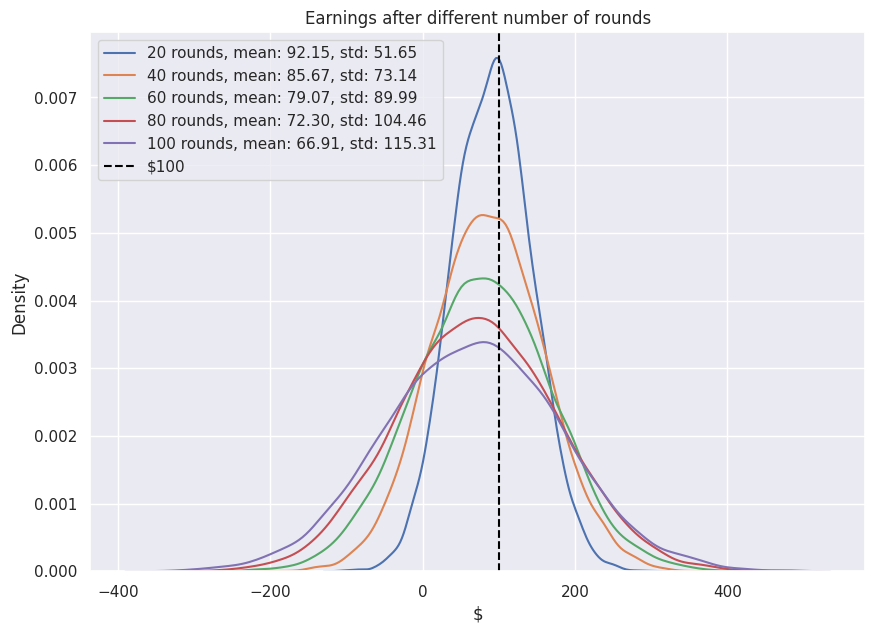

In [ ]:
montecarlo([20, 40, 60, 80, 100], 10000)

We see that our expected earning decreases but the variance increases the more rounds we play.

##Creating our agent.

###Implementación sencilla de Q learning.

Aplicamos Q-learning para que un agente aprenda a navegar un laberinto 3x3 con un hoyo en el centro (posición 1,1) y meta en (2,2), el cual es la única casilla con recompensa diferente de 0. A continuación implementamos la clase del laberinto y posteriormente aplicamos Q-learning para aprender la matríz de transición Q de estado-acción:

In [ ]:
class Env:
    def __init__(self, hole=(1, 1), goal=(2, 2)):
        self.state = (0, 0)  # initial position as coordinates
        self.hole = hole
        self.goal = goal
        self.actions = [0, 1, 2, 3]  # 0: left, 1: down, 2: right, 3: up
        self.map = [[0,1,2], [3,4,5], [6,7,8]]

    def reset(self):
        self.state = (0, 0)  # Reset to the initial position

    def step(self, action):
        if action not in self.actions:
            raise ValueError('Not a valid action')

        position = self.state

        if action == 0:  # left
            new_position = (position[0], max(position[1] - 1, 0))
        elif action == 1:  # down
            new_position = (min(position[0] + 1, 2), position[1])
        elif action == 2:  # right
            new_position = (position[0], min(position[1] + 1, 2))
        else:  # up
            new_position = (max(position[0] - 1, 0), position[1])

        if new_position == self.hole:
            self.reset()
            return 0, True  # reward=0, done=True
        elif new_position == self.goal:
            self.reset()
            return 1, True  # reward=1, done=True
        else:
            self.state = new_position
            return 0, False

In [ ]:
# Initialize the Frozen Lake environment
env = Env()

# Q-learning parameters
alpha = 0.8   # Learning rate
gamma = 0.95  # Discount factor
epsilon = 0.3 # Exploration rate
num_episodes =  100000
max_steps = 100

# Initialize Q-table with zeros
Q = np.zeros((9, len(env.actions)))

# Q-learning algorithm
for episode in range(num_episodes):
    env.reset()
    done = False
    for step in range(max_steps):
        if np.random.uniform(0, 1) < epsilon:
            # Explore: choose a random action
            action = random.choice(env.actions)
        else:
            # Exploit: choose the action with max value (greedy action)
            action = np.argmax(Q[env.map[env.state[0]][env.state[1]], :]) #pasamos de coordenadas (i,j) del state a un entero con ayuda de env.map

        state1 = env.map[env.state[0]][env.state[1]]
        # Take the action and observe the next state and reward
        reward, done = env.step(action) #al dar el step el env.state cambia

        # Update Q-value
        Q[state1, action] = Q[state1, action] + alpha * (reward + gamma * np.max(Q[env.map[env.state[0]][env.state[1]], :]) - Q[state1, action])

        # If the episode is done, exit the loop
        if done:
            break

# Print the final Q-table
print("Final Q-Table:")
print(Q)

Final Q-Table:
[[4.39101722 4.62212339 4.62212339 4.39101722]
 [4.39101722 4.39101722 4.86539304 4.62212339]
 [4.62212339 5.12146636 4.86539304 4.86539304]
 [4.62212339 4.86539304 4.39101722 4.39101722]
 [0.         0.         0.         0.        ]
 [4.39101722 5.39101722 5.12146636 4.86539304]
 [4.86539304 4.86539304 5.12146636 4.62212339]
 [4.86539304 5.12146636 5.39101722 4.39101722]
 [0.         0.         0.         0.        ]]


In [ ]:
mat = []
for i in Q:
  mat.append(np.argmax(i))
mat = np.array(mat)
mat.reshape((3,3))

array([[1, 2, 1],
       [1, 0, 1],
       [2, 2, 0]])

Hasta que ajustamos el epsilon a 0.3, haciendo que nuestro agente explore más, finalmente llegamos a tener acciones para las posiciones (0,1), (0,2) y (1,2).

###Obtención gradual de DQN.



El proceso de entrenamiento de la red artificial que aproxima la función Q(s, a) para que nuestro agente llegue a una política óptima lo dividimos en tres pasos. Primero obtuvimos los pesos iniciales de la red, permitiendole al agente únicamente elegir una acción de entre 'hit', 'stand', y 'double down'. De aquí obtuvimos datos X, 'y' donde la X contiene un vector que describe el estado y la acción y la 'y' la recompensa obtenida. Después entrenamos la red y con los pesos obtenidos volvimos a obtener datos pero ahora introduciendo la acción de 'split', la cual introduce más complejidad en el cálculo de la recompensa pues genera más de una 'hand' que se enfrenta a la del dealer. En esta parte hicimos que el agente siempre elija split cuando se tenga un par. Posteriormente volvimos a entrenar la red. Finalmente, con estos nuevos pesos generamos datos y continuamos entrenando a la red de forma iterativa en un entorno 'real' abierto a todas las posibilidades en la que nuestro agente opta por una política epsilon greedy, la cual hace uso de la función Q(s ,a) que cuenta con pesos iniciales previamente construidos, por lo que se espera que se converja a una política óptima de forma más rápida.

####Obtención de pesos iniciales:

La siguiente clase es para simular rondas de blackjack de un jugador contra un dealer que usa 6 card decks. En estas rondas se tomará una sola acción aleatoria, de modo que la ronda acabe inmediatamente después y se obtenga una recompensa. Por ello, omitimos la acción de split, ya que no hay forma de obtener una recompensa inmediata. Entrenaremos una red neuronal fully connected con estos datos: 'X': 15 características del estado y la acción, 'y': recompensa. Optamos por 15 características: la cuenta de cartas con face value de 2 que han salido, de 3, 4, 5, 6, 7, 8, 9, 10 y 11, así como el running count del método de contar cartas high-low, el face value de la carta visible del dealer, la suma de las dos cartas del jugador, el número de aces que tiene el jugador, y finalmente la acción a tomar: 0 para stand, 1 para hit, y 2 para double.

In [ ]:
class bjData():
  def __init__(self, nDecks=6, hitsSoft17=True):
    '''
    nDecks: number of decks to be used.
    hitsSoft17: True or False depending whether the dealer hits on Ace and 6 or doesn't.
      Observations:
    We allow the player to double down after splitting.
    We won't allow the player to surrender since most casinos don't have this variant.
    We won't consider insurance (according to the basic strategy the player most never buy it anyways).
    '''
    self.nDecks = nDecks
    self.hitsSoft17 = hitsSoft17
    self.values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] #11 will be treated as an ace
    self.whichDeck = 'original'
    self.shuffle()
    self.remainder = [] #contains the cards played after each round.
    self.dealer = [] #dealer's hand
    self.player = [] #player's hand, a list of lists (since he can have multiple hands after splitting)
    self.doubledDown = False #boolean values indicating whether a hand has been doubled down
    self.actions = {'stand': 0, 'hit': 1, 'double': 2}
    self.features = [0] * 15
    self.X = []
    self.y = []

  def shuffle(self):
    if self.whichDeck=='original':
      self.features = [0] * 15
      self.deck = [value for value in self.values for i in range(4)] * self.nDecks
      random.shuffle(self.deck)
      self.remainder = []
    elif self.whichDeck=='remainder':
      random.shuffle(self.remainder)
      self.deck = self.remainder.copy()
      self.remainder = []

  def popF(self):
    '''
    Aparte de self.deck.pop(), añadimos la carta a la cuenta de cada carta en nuestra list de features.
    '''
    carta = self.deck.pop()
    self.remainder.append(carta)
    self.features[carta-2] += 1
    if carta<7:
      self.features[10] += 1 #features[10] tiene la cuenta de high/low cards
    elif carta>9:
      self.features[10] -= 1
    else:
      pass #se suma 0

    return carta

  def checkCardsLeft(self):
    '''
    In case there are no more cards left in the deck, it shuffles and uses the remaining cards to finish the hand.
    It is called when someone wishes to hit.
    '''
    if len(self.deck) == 0: #no more cards left
      self.whichDeck = 'remainder'
      self.shuffle()
    else:
      return

  def hit(self, who, index=0):
    '''
    who: 'dealer' or 'player'.
    index: the index of the hand that the player wants to hit (in case he splitted).
    '''
    self.checkCardsLeft()
    if who=='dealer':
      self.dealer.append(self.popF())
    elif who=='player':
      #self.player[index].append(self.popF())
      self.player.append(self.popF())

  def dealersTurn(self):
    '''
    Hits until the sum is more or equal to 17. Handles special case of soft 17 and of aces valued as 11 needing to change to 1.
    '''
    while sum(self.dealer) < 17:
      self.hit('dealer')
      if sum(self.dealer) > 21 and 11 in self.dealer:
        ind = self.dealer.index(11)
        self.dealer[ind] = 1
      if sum(self.dealer) == 17 and 11 in self.dealer and self.hitsSoft17: #soft 17
        self.hit('dealer')
        if sum(self.dealer) > 21:
          ind = self.dealer.index(11)
          self.dealer[ind] = 1

  def win(self, blackjack=False, doubledDown=False):
    self.wins['player'] += 1
    if blackjack:
      self.playersMoney += self.minBet + self.bjRatio*self.minBet
    else:
      if not doubledDown:
        self.playersMoney += 2*self.minBet
      else:
        self.playersMoney += 4*self.minBet

  def loss(self):
    self.wins['dealer'] += 1

  def push(self):
    self.wins['pushes'] += 1
    self.playersMoney += self.minBet

  def simulation(self, n):
    '''
    n: number of rounds to simulate.
    We created this function since we can't include a for loop in round() because we call it recursively in
    case of a split.
    '''
    for _ in range(n):
      self.round()
    return np.array(self.X), np.array(self.y)

  def cardsEndOfRound(self):
    '''
    We check if we used the original or remainder deck in this round:
    '''
    self.dealer = []
    self.player = []
    if self.whichDeck=='remainder':
      #we shuffle all the cards and set the remainder deck to an empty list
      self.whichDeck = 'original'
      self.shuffle()

  def round(self):
    '''
    Conducts a single round of blackjack, from when the player places his bet to when the round finishes and
    the player is handed money or not.
    '''
    reward = 0

    #dealer hands cards:
    self.hit('player')
    self.hit('dealer')
    self.hit('player')
    self.hit('dealer')

    self.features[11] = self.dealer[1]
    self.features[12] = sum(self.player)
    self.features[13] = int(11 in self.player)

    #player's decisions:
    if (self.player[0] + self.player[1]) == 21: #blackjack
      action = None
    else:
      #Random action:
      action = random.choice(list(self.actions.keys()))
      self.features[14] = self.actions[action]
      feat = self.features
      feat[10] /= self.nDecks
      if action == 'double':
        self.hit('player')
        self.doubledDown = True
      elif action == 'hit':
        self.hit('player')
      elif action == 'stand':
        pass

    #End of round, now comes the dealer's turn and discover who won
    self.dealersTurn()

   # print(self.player, self.dealer)
    if sum(self.player)==21 and sum(self.dealer)==21:
      reward = 0
    elif sum(self.player)==21 and sum(self.dealer)!=21:
      reward = 2 if self.doubledDown else 1
    elif sum(self.dealer)==21:
      reward = -2 if self.doubledDown else -1
    elif sum(self.player)>21:
      reward = -2 if self.doubledDown else -1
    elif sum(self.dealer)==sum(self.player):
      reward = 0
    elif sum(self.player)>sum(self.dealer):
      reward = 2 if self.doubledDown else 1
    elif sum(self.player)<sum(self.dealer):
      if sum(self.dealer)>21:
        reward = 2 if self.doubledDown else 1
      else:
        reward = -2 if self.doubledDown else -1

    self.cardsEndOfRound()

    if action != None:
      self.X.append(feat)
      self.y.append(reward)

    self.doubledDown = False

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Ahora simulamos 1 millón de rondas y obtenemos la recompensa para cada una al tomar una acción aleatoria:

In [ ]:
simul = bjData()
X, y = simul.simulation(1000000)

Entrenamos la red neuronal, con tres hidden layers the 64, 32, y 16 neuronas y usando la Huber loss como se hizo en el artículo https://cs230.stanford.edu/files_winter_2018/projects/6940282.pdf

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.1)

model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss=tf.keras.losses.Huber())

#Train:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(xTrain, yTrain, epochs=5, callbacks=[early_stopping])

test_loss = model.evaluate(xTest, yTest)
print(f'Test loss: {test_loss}')

Epoch 1/5
26786/26790 [============================>.] - ETA: 0s - loss: 0.6298

26790/26790 [==============================] - 80s 3ms/step - loss: 0.6298
Epoch 2/5
26785/26790 [============================>.] - ETA: 0s - loss: 0.6213

26790/26790 [==============================] - 70s 3ms/step - loss: 0.6213
Epoch 3/5
26789/26790 [============================>.] - ETA: 0s - loss: 0.6213

26790/26790 [==============================] - 71s 3ms/step - loss: 0.6213
Epoch 4/5
26766/26790 [============================>.] - ETA: 0s - loss: 0.6213

26790/26790 [==============================] - 68s 3ms/step - loss: 0.6213
Epoch 5/5
26790/26790 [==============================] - ETA: 0s - loss: 0.6213

2977/2977 [==============================] - 5s 2ms/step - loss: 0.6229
Test loss: 0.6229022145271301


Guardamos los pesos:

In [ ]:
model.save_weights('initial_weights.h5')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


####Obtención de pesos al introducir split:

Ahora crearemos una función donde se tendrá la política de la elección de acciones. Antes de que sea epsilon-greedy, simularemos algunos episodios en donde siempre que se tenga par se elija split para que esta acción no se vea en desventaja al tener valores q(s, a) iniciales desconocidos porque la red no ha visto (s, a=3) (split).

Evaluamos los pesos obtenidos anteriormente:

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss=tf.keras.losses.Huber())

#We initialize model with dummy data:
dummy_input = np.zeros((1, 15))  # Assuming your input has 15 features
with contextlib.redirect_stdout(open(os.devnull, 'w')):
  model.predict(dummy_input)
model.load_weights('/content/initial_weights.h5')

x = np.array([[0,0,0,0,0,0,0,0,0,0,0,10,8,0,2]])
with contextlib.redirect_stdout(open(os.devnull, 'w')):
  pred = model.predict(x)[0][0]
pred

In [ ]:
class bjDream():
  def __init__(self, initialWeights, nDecks=6, hitsSoft17=True, epsilon=0.3):
    '''
    initialWeights: string with the route to the weights.h5 file to initialize the neural net.
    nDecks: number of decks to be used.
    hitsSoft17: True or False depending whether the dealer hits on Ace and 6 or doesn't.
    epsilon: for the epsilon-greedy action policy.
      Observations:
    We allow the player to double down after splitting.
    We won't allow the player to surrender since most casinos don't have this variant.
    We won't consider insurance (according to the basic strategy the player most never buy it anyways).
    There won't be an additional award for the agent for getting a blackjack.
    '''
    self.nDecks = nDecks
    self.hitsSoft17 = hitsSoft17
    self.epsilon = epsilon
    self.values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] #11 will be treated as an ace
    self.whichDeck = 'original'
    self.shuffle()
    self.remainder = [] #contains the cards played after each round.
    self.dealer = [] #dealer's hand
    self.player = [[]] #player's hand, a list of lists (since he can have multiple hands after splitting)
    self.doubledDown = [False] #boolean values indicating whether a hand has been doubled down
    self.stood = [False] #similar to doubledDown but with stand
    self.actions = {'stand': 0, 'hit': 1, 'double': 2} #incluimos split después de entrenar con split forzoso al tener par
    self.features = [0] * 15
    self.features2 = [0] * 15
    self.X = []
    self.y = []
    self.firstAction = None #the first action taken in a given hand
    self.reward = 0

    seed = 42
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    #Fully connected network architecture:
    self.model = Sequential()
    self.model.add(Dense(64, activation='relu'))
    self.model.add(Dense(32, activation='relu'))
    self.model.add(Dense(16, activation='relu'))
    self.model.add(Dense(1))
    self.model.compile(optimizer='adam', loss=tf.keras.losses.Huber())
    #We initialize model with dummy data:
    dummy_input = np.zeros((1, len(self.features)))  # Assuming your input has 15 features
    self.model.predict(dummy_input)
    self.model.load_weights(initialWeights)

  def shuffle(self):
    if self.whichDeck=='original':
      self.features = [0] * 15
      self.deck = [value for value in self.values for i in range(4)] * self.nDecks
      random.shuffle(self.deck)
      self.remainder = []
    elif self.whichDeck=='remainder':
      random.shuffle(self.remainder)
      self.deck = self.remainder.copy()
      self.remainder = []

  def popF(self):
    '''
    Aparte de self.deck.pop(), añadimos la carta a la cuenta de cada carta en nuestra list de features.
    '''
    carta = self.deck.pop()
    self.remainder.append(carta)
    self.features[carta-2] += 1
    if carta<7:
      self.features[10] += 1 #features[10] tiene la cuenta de high/low cards
    elif carta>9:
      self.features[10] -= 1
    else:
      pass #se suma 0
    return carta

  def checkCardsLeft(self):
    '''
    In case there are no more cards left in the deck, it shuffles and uses the remaining cards to finish the hand.
    It is called when someone wishes to hit.
    '''
    if len(self.deck) == 0: #no more cards left
      self.whichDeck = 'remainder'
      self.shuffle()
    else:
      return

  def hit(self, who, index=0):
    '''
    who: 'dealer' or 'player'.
    index: the index of the hand that the player wants to hit (in case he splitted).
    '''
    self.checkCardsLeft()
    if who=='dealer':
      self.dealer.append(self.popF())
    elif who=='player':
      self.player[index].append(self.popF())

  def split(self, index):
    '''
    Obtains the index of the hand the player wishes to split (in case he already has more than one hand)
    and returns the splited hand, for example [[4, 5], [2, 2]] returns [[4, 5], [2], [2]] for index=1
    '''
    splitted = []
    for i, hand in enumerate(self.player):
      if i == index:
        splitted.extend([[item] for item in hand])
      else:
        splitted.append(hand)
    self.player = splitted
    self.doubledDown[index:index+1] = [False, False]
    self.stood[index:index+1] = [False, False]

  def dealersTurn(self):
    '''
    Hits until the sum is more or equal to 17. Handles special case of soft 17 and of aces valued as 11 needing to change to 1.
    '''
    while sum(self.dealer) < 17:
      self.hit('dealer')
      if sum(self.dealer) > 21 and 11 in self.dealer:
        ind = self.dealer.index(11)
        self.dealer[ind] = 1
      if sum(self.dealer) == 17 and 11 in self.dealer and self.hitsSoft17: #soft 17
        self.hit('dealer')
        if sum(self.dealer) > 21:
          ind = self.dealer.index(11)
          self.dealer[ind] = 1

  def win(self, doubledDown=False):
    if not doubledDown:
      self.reward += 1
    else:
      self.reward += 2

  def loss(self, doubledDown=False):
    if not doubledDown:
      self.reward -= 1
    else:
      self.reward -= 2

  def push(self):
    self.reward += 0

  def simulation(self, n):
    '''
    Returns the weights of the neural network that approximates Q(s, a)
    n: number of rounds to simulate.
    We created this function since we can't include a for loop in round() because we call it recursively in
    case of a split.
    '''
    for _ in range(n):
      reward = 0
      self.round()
    return X, y

  def cardsEndOfRound(self):
    '''
    We check if we used the original or remainder deck in this round:
    '''
    self.dealer = []
    self.player = [[]]
    if self.whichDeck=='remainder':
      #we shuffle all the cards and set the remainder deck to an empty list
      self.whichDeck = 'original'
      self.shuffle()

  def actionPolicy(self, actType='random'):
    if actType == 'random':
      return random.choice(list(self.actions.values()))
    elif actType == 'e-greedy':
      if np.random.uniform(0, 1) < epsilon:
        return random.choice(list(self.actions.values()))
      else:
        qVals = []
        featuresAux = self.features.copy()
        for act in list(self.actions.values()):
          featuresAux[14] = act
          qVals.append(self.model.predict(np.array([featuresAux]))[0][0])
        return np.argmax(qVals)

  def round(self):
    '''
    Conducts a single round of blackjack, from when the player places his bet to when the round finishes and
    the player is handed money or not. It gathers the state-action and reward.
    '''

    #If the round has just started, dealer hands cards:
    if self.player==[[]]:
      self.hit('player', 0)
      self.hit('dealer')
      self.hit('player', 0)
      self.hit('dealer')

      self.features[11] = self.dealer[1]
      self.features[12] = sum(self.player[0])
      self.features[13] = self.player[0].count(11)

    #If the function is called after splitting, dealer hands cards to each new game:
    for index, hand in enumerate(self.player):
      if len(hand)==1:
        self.hit('player', index)

    #Player decisions:
    for index, hand in enumerate(self.player):
        if self.doubledDown[index] or self.stood[index] or sum(hand)>=21:
          action = True
          continue

        if (hand[0] + hand[1]) == 21 and len(hand)==2:
          self.stood[index] = True
          #if player gets a blackjack right away agent can't make further decisions, so we skip this hand
          if len(self.player) == 1:
            action = None
          else:
            action = True

        else:
          #we obtain the action that the agent choses
          if hand[0]==hand[1] and len(hand)==2: #pair
            action = 3 #split
          else:
            action = self.actionPolicy('random')
            if action == self.actions['double'] and len(hand)>2:
              action = self.actions['hit']

          #we save the first action taken in the round
          if len(hand) == 2 and len(self.player) == 1:
            self.features[14] = action
            self.features2 = self.features.copy()
            self.features2[10] /= self.nDecks

          #we execute the chosen action
          if action == self.actions['double']:
            self.hit('player', index)
            self.doubledDown[index] = True
          elif action == self.actions['hit']:
            self.hit('player')
            self.round()
            return
          elif action == self.actions['stand']:
            self.stood[index] = True
          elif action == 3: #split
            self.split(index)
            self.round()
            return

    #End of round, now comes the dealer's turn and discover who won
    self.dealersTurn()
    for index, hand in enumerate(self.player):
        if sum(hand)==21 and sum(self.dealer)==21:
          self.reward += 0
        elif sum(hand)==21 and sum(self.dealer)!=21:
          self.reward += 2 if self.doubledDown else 1
        elif sum(self.dealer)==21:
          self.reward -= 2 if self.doubledDown else -1
        elif sum(hand)>21:
          self.reward -= 2 if self.doubledDown else -1
        elif sum(self.dealer)==sum(hand):
          self.reward += 0
        elif sum(hand)>sum(self.dealer):
          self.reward += 2 if self.doubledDown else 1
        elif sum(hand)<sum(self.dealer):
          if sum(self.dealer)>21:
            self.reward += 2 if self.doubledDown else 1
          else:
            self.reward -= 2 if self.doubledDown else -1

    self.cardsEndOfRound()

    if action != None:
      self.X.append(self.features2)
      self.y.append(self.reward)

    self.doubledDown = [False]
    self.stood = [False]

In [ ]:
weights = '/content/initial_weights.h5'
dqn = bjDream(weights)
X, y = dqn.simulation(100000)

1/1 [==============================] - 0s 299ms/step


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.1)

model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss=tf.keras.losses.Huber())

#Train:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(xTrain, yTrain, epochs=5, callbacks=[early_stopping])

test_loss = model.evaluate(xTest, yTest)
print(f'Test loss: {test_loss}')

Epoch 1/5
26785/26790 [============================>.] - ETA: 0s - loss: 0.6257

26790/26790 [==============================] - 69s 3ms/step - loss: 0.6258
Epoch 2/5
26789/26790 [============================>.] - ETA: 0s - loss: 0.6213

26790/26790 [==============================] - 66s 2ms/step - loss: 0.6213
Epoch 3/5
26787/26790 [============================>.] - ETA: 0s - loss: 0.6213

26790/26790 [==============================] - 70s 3ms/step - loss: 0.6213
Epoch 4/5
26774/26790 [============================>.] - ETA: 0s - loss: 0.6213

26790/26790 [==============================] - 84s 3ms/step - loss: 0.6213
Epoch 5/5
23382/26790 [=========================>....] - ETA: 8s - loss: 0.6218

In [ ]:
model.save_weights('splitWeights.h5')

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss=tf.keras.losses.Huber())

#We initialize model with dummy data:
dummy_input = np.zeros((1, 15))  # Assuming your input has 15 features
model.predict(dummy_input)
model.load_weights('/content/splitWeights.h5')

actions = [0, 1, 2, 3]
x = np.array(np.array([[0,0,0,0,0,0,0,0,0,0,0,10,22,2,i] for i in actions]))
for i in range(3*10): #es para ver cuánto tarda
  preds = []
  preds.append(model.predict(x))
preds

1/1 [==============================] - 0s 19ms/step


[array([[-1.0266986],
        [-1.0299904],
        [-1.026375 ],
        [-0.9848149]], dtype=float32)]

Vemos que nuestro agente aprendíó a hacer un split cuando se tiene un par de aces, lo cual es la estrategia óptima.

####Entrenamiento definitivo de la red:

Now we make a similar class with a few adjustments. We will now include the split action in the self.actions so that our agent is now free to chose it or not whenever the player has a pair. Also, we will now create a new dqn() function that calls simulation() to obtain data, specifically to train the network every 50,000 data points gathered. At the end of dqn() we shall save the weights of the model to the 'content' file of our google colab session.

In [ ]:
class bjDream():
  def __init__(self, initialWeights, policy='random', nDecks=6, hitsSoft17=True, epsilon=0.3):
    '''
    initialWeights: string with the route to the weights.h5 file to initialize the neural net.
    policy: the policy to use in the function actionPolicy(), either random or epsilon greedy.
    nDecks: number of decks to be used.
    hitsSoft17: True or False depending whether the dealer hits on Ace and 6 or doesn't.
    epsilon: for the epsilon-greedy action policy.
      Observations:
    We allow the player to double down after splitting.
    We won't allow the player to surrender since most casinos don't have this variant.
    We won't consider insurance (according to the basic strategy the player most never buy it anyways).
    There won't be an additional award for the agent for getting a blackjack.
    '''
    self.nDecks = nDecks
    self.hitsSoft17 = hitsSoft17
    self.epsilon = epsilon
    self.values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] #11 will be treated as an ace
    self.whichDeck = 'original'
    self.shuffle()
    self.remainder = [] #contains the cards played after each round.
    self.dealer = [] #dealer's hand
    self.player = [[]] #player's hand, a list of lists (since he can have multiple hands after splitting)
    self.doubledDown = [False] #boolean values indicating whether a hand has been doubled down
    self.stood = [False] #similar to doubledDown but with stand
    self.actions = {'stand': 0, 'hit': 1, 'double': 2, 'split': 3} #incluimos split después de entrenar con split forzoso al tener par
    self.features = [0] * 15
    self.features2 = [0] * 15 #here we save the snapshot of the round right after knowing the first action of the player
    self.X = []
    self.y = []
    self.firstAction = None #the first action taken in a given hand
    self.reward = 0

    seed = 42
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    #Fully connected network architecture:
    self.model = Sequential()
    self.model.add(Dense(64, activation='relu'))
    self.model.add(Dense(32, activation='relu'))
    self.model.add(Dense(16, activation='relu'))
    self.model.add(Dense(1))
    self.model.compile(optimizer='adam', loss=tf.keras.losses.Huber())
    #We initialize model with dummy data:
    dummy_input = np.zeros((1, len(self.features)))  # Assuming your input has 15 features
    with contextlib.redirect_stdout(open(os.devnull, 'w')):
      self.model.predict(dummy_input)
    self.model.load_weights(initialWeights)

  def shuffle(self):
    if self.whichDeck=='original':
      self.features = [0] * 15
      self.deck = [value for value in self.values for i in range(4)] * self.nDecks
      random.shuffle(self.deck)
      self.remainder = []
    elif self.whichDeck=='remainder':
      random.shuffle(self.remainder)
      self.deck = self.remainder.copy()
      self.remainder = []

  def popF(self):
    '''
    Aparte de self.deck.pop(), añadimos la carta a la cuenta de cada carta en nuestra list de features.
    '''
    carta = self.deck.pop()
    self.remainder.append(carta)
    self.features[carta-2] += 1
    if carta<7:
      self.features[10] += 1 #features[10] tiene la cuenta de high/low cards
    elif carta>9:
      self.features[10] -= 1
    else:
      pass #se suma 0
    return carta

  def checkCardsLeft(self):
    '''
    In case there are no more cards left in the deck, it shuffles and uses the remaining cards to finish the hand.
    It is called when someone wishes to hit.
    '''
    if len(self.deck) == 0: #no more cards left
      self.whichDeck = 'remainder'
      self.shuffle()
    else:
      return

  def hit(self, who, index=0):
    '''
    who: 'dealer' or 'player'.
    index: the index of the hand that the player wants to hit (in case he splitted).
    '''
    self.checkCardsLeft()
    if who=='dealer':
      self.dealer.append(self.popF())
    elif who=='player':
      self.player[index].append(self.popF())

  def split(self, index):
    '''
    Obtains the index of the hand the player wishes to split (in case he already has more than one hand)
    and returns the splited hand, for example [[4, 5], [2, 2]] returns [[4, 5], [2], [2]] for index=1
    '''
    splitted = []
    for i, hand in enumerate(self.player):
      if i == index:
        splitted.extend([[item] for item in hand])
      else:
        splitted.append(hand)
    self.player = splitted
    self.doubledDown[index:index+1] = [False, False]
    self.stood[index:index+1] = [False, False]

  def dealersTurn(self):
    '''
    Hits until the sum is more or equal to 17. Handles special case of soft 17 and of aces valued as 11 needing to change to 1.
    '''
    while sum(self.dealer) < 17:
      self.hit('dealer')
      if sum(self.dealer) > 21 and 11 in self.dealer:
        ind = self.dealer.index(11)
        self.dealer[ind] = 1
      if sum(self.dealer) == 17 and 11 in self.dealer and self.hitsSoft17: #soft 17
        self.hit('dealer')
        if sum(self.dealer) > 21:
          ind = self.dealer.index(11)
          self.dealer[ind] = 1

  def win(self, doubledDown=False):
    if not doubledDown:
      self.reward += 1
    else:
      self.reward += 2

  def loss(self, doubledDown=False):
    if not doubledDown:
      self.reward -= 1
    else:
      self.reward -= 2

  def push(self):
    self.reward += 0

  def simulation(self, n):
    '''
    Returns the weights of the neural network that approximates Q(s, a)
    n: number of rounds to simulate.
    We created this function since we can't include a for loop in round() because we call it recursively in
    case of a split.
    '''
    self.X = []
    self.y = []
    for _ in range(n):
      reward = 0
      self.round()

  def dqn(self, n):
    for i in tqdm(range(n)):
      self.simulation(50000)
      scaler = StandardScaler()
      X_scaled = scaler.fit_transform(np.array(self.X))
      X_scaled, y = shuffle(X_scaled, np.array(self.y))
      self.model.fit(X_scaled, y.reshape(-1, 1), epochs=1)
    self.model.save_weights('dqnWeights.h5')

  def cardsEndOfRound(self):
    '''
    We check if we used the original or remainder deck in this round:
    '''
    self.dealer = []
    self.player = [[]]
    if self.whichDeck=='remainder':
      #we shuffle all the cards and set the remainder deck to an empty list
      self.whichDeck = 'original'
      self.shuffle()

  def actionPolicy(self, actType='random', split=False):
    #if split=False, the player hasn't a pair and therefore can't split
    if actType == 'random':
      if split:
        return random.choice(list(self.actions.values()))
      else:
        return random.choice(list(self.actions.values())[:-1]) #excluimos a split
    elif actType == 'e-greedy':
      if np.random.uniform(0, 1) < self.epsilon:
        if split:
          return random.choice(list(self.actions.values()))
        else:
          return random.choice(list(self.actions.values())[:-1]) #excluimos a split
      else:
        qVals = []
        featuresAux = self.features.copy()
        if split:
          for act in list(self.actions.values()):
            featuresAux[14] = act
            with contextlib.redirect_stdout(open(os.devnull, 'w')): #para que no imprima nada en consola
              qVals.append(self.model.predict(np.array([featuresAux]))[0][0])
          return np.argmax(qVals)
        else: #excluimos a split
          for act in list(self.actions.values())[:-1]:
            featuresAux[14] = act
            with contextlib.redirect_stdout(open(os.devnull, 'w')):
              qVals.append(self.model.predict(np.array([featuresAux]))[0][0])
          return np.argmax(qVals)


  def round(self):
    '''
    Conducts a single round of blackjack, from when the player places his bet to when the round finishes and
    the player is handed money or not. It gathers the state-action and reward.
    '''

    #If the round has just started, dealer hands cards:
    if self.player==[[]]:
      self.hit('player', 0)
      self.hit('dealer')
      self.hit('player', 0)
      self.hit('dealer')

      self.features[11] = self.dealer[1]
      self.features[12] = sum(self.player[0])
      self.features[13] = self.player[0].count(11)

    #If the function is called after splitting, dealer hands cards to each new game:
    for index, hand in enumerate(self.player):
      if len(hand)==1:
        self.hit('player', index)

    #Player decisions:
    for index, hand in enumerate(self.player):
        if self.doubledDown[index] or self.stood[index] or sum(hand)>=21:
          action = True #solo por poner algo para se evalue su valor abajo
          continue

        if (hand[0] + hand[1]) == 21 and len(hand)==2:
          self.stood[index] = True
          #if player gets a blackjack right away agent can't make further decisions, so we skip this hand
          if len(self.player) == 1:
            action = None
          else:
            action = True

        else:
          if hand[0] == hand[1] and len(hand)==2: #pair
            action = self.actionPolicy('random', True)
          else:
            action = self.actionPolicy('random')

          if action == self.actions['double'] and len(hand)>2:
            action = self.actions['hit']

          #we save the first action taken in the round
          if len(hand) == 2 and len(self.player) == 1:
            self.features[14] = action
            self.features2 = self.features.copy()
            self.features2[10] /= self.nDecks

          #we execute the chosen action
          if action == self.actions['double']:
            self.hit('player', index)
            self.doubledDown[index] = True
          elif action == self.actions['hit']:
            self.hit('player')
            self.round()
            return
          elif action == self.actions['stand']:
            self.stood[index] = True
          elif action == 3: #split
            self.split(index)
            self.round()
            return

    #End of round, now comes the dealer's turn and discover who won
    self.dealersTurn()
    for index, hand in enumerate(self.player):
        if sum(hand)==21 and sum(self.dealer)==21:
          self.reward += 0
        elif sum(hand)==21 and sum(self.dealer)!=21:
          self.reward += 2 if self.doubledDown else 1
        elif sum(self.dealer)==21:
          self.reward -= 2 if self.doubledDown else -1
        elif sum(hand)>21:
          self.reward -= 2 if self.doubledDown else -1
        elif sum(self.dealer)==sum(hand):
          self.reward += 0
        elif sum(hand)>sum(self.dealer):
          self.reward += 2 if self.doubledDown else 1
        elif sum(hand)<sum(self.dealer):
          if sum(self.dealer)>21:
            self.reward += 2 if self.doubledDown else 1
          else:
            self.reward -= 2 if self.doubledDown else -1

    self.cardsEndOfRound()

    if action != None:
      self.X.append(self.features2)
      self.y.append(self.reward)

    self.doubledDown = [False]
    self.stood = [False]

In [ ]:
bj = bjDream('/content/splitWeights.h5', 'random')
bj.dqn(10)

  0%|          | 0/10 [00:00<?, ?it/s]

1563/1563 [==============================] - 6s 3ms/step - loss: 13845.7012


 10%|█         | 1/10 [00:07<01:05,  7.30s/it]

1563/1563 [==============================] - 6s 4ms/step - loss: 12687.9131


 20%|██        | 2/10 [00:14<00:57,  7.25s/it]

1563/1563 [==============================] - 6s 4ms/step - loss: 11383.8281


 30%|███       | 3/10 [00:35<01:35, 13.67s/it]

1563/1563 [==============================] - 5s 3ms/step - loss: 11207.1074


 40%|████      | 4/10 [00:42<01:04, 10.73s/it]

1563/1563 [==============================] - 7s 4ms/step - loss: 10978.1719


 50%|█████     | 5/10 [00:49<00:48,  9.72s/it]

1563/1563 [==============================] - 5s 3ms/step - loss: 10944.1240


 60%|██████    | 6/10 [01:01<00:40, 10.21s/it]

1563/1563 [==============================] - 5s 3ms/step - loss: 10985.1611


 70%|███████   | 7/10 [01:12<00:31, 10.60s/it]

1563/1563 [==============================] - 5s 3ms/step - loss: 11097.7686


 80%|████████  | 8/10 [01:18<00:18,  9.21s/it]

1563/1563 [==============================] - 6s 4ms/step - loss: 11032.9648


 90%|█████████ | 9/10 [01:29<00:09,  9.81s/it]

1563/1563 [==============================] - 6s 4ms/step - loss: 10817.4922


100%|██████████| 10/10 [01:41<00:00, 10.10s/it]


###Evaluación de nuestra política:

Ahora creamos una clase para usar el modelo aprendido para simular muchas rondas de blackjack y al final obtenemos un diccionario con la cuenta de wins, losses y pushes.

Un ejemplo de la predicción de nuestro modelo:

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss=tf.keras.losses.Huber())

#We initialize model with dummy data:
dummy_input = np.zeros((1, 15))  # Assuming your input has 15 features
with contextlib.redirect_stdout(open(os.devnull, 'w')):
  model.predict(dummy_input)
model.load_weights('/content/dqnWeights.h5')

# Collect all feature vectors for the actions
featureBatch = []
for i in [0, 1, 2, 3]:
    featureBatch.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 8, 0, i])

# Convert to numpy array
featureBatch = np.array(featureBatch)

# Normalize the featureBatch
scaler = StandardScaler()
featureBatch = scaler.fit_transform(featureBatch)

# Make batch predictions
with contextlib.redirect_stdout(open(os.devnull, 'w')):
    preds = model.predict(featureBatch).flatten()

preds

array([-399229.7 , -399614.34, -399999.1 , -400383.72], dtype=float32)

In [ ]:
class bjEvaluation():
  def __init__(self, weights, nDecks=6, hitsSoft17=True):
    '''
    weights: string with the route to the weights.h5 file to initialize the neural net.
    nDecks: number of decks to be used.
    hitsSoft17: True or False depending whether the dealer hits on Ace and 6 or doesn't.
      Observations:
    We allow the player to double down after splitting.
    We won't allow the player to surrender since most casinos don't have this variant.
    We won't consider insurance (according to the basic strategy the player most never buy it anyways).
    There won't be an additional award for the agent for getting a blackjack.
    '''
    self.nDecks = nDecks
    self.hitsSoft17 = hitsSoft17
    self.values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
    self.whichDeck = 'original'
    self.shuffle()
    self.remainder = []
    self.dealer = []
    self.player = [[]]
    self.doubledDown = [False]
    self.stood = [False]
    self.actions = {'stand': 0, 'hit': 1, 'double': 2, 'split': 3}
    self.X = []
    self.y = []
    self.features = [0] * 15
    self.wins = defaultdict(int)
    self.playersMoney = 100
    self.splits = 0

    seed = 42
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    #Fully connected network architecture:
    self.model = Sequential()
    self.model.add(Dense(64, activation='relu'))
    self.model.add(Dense(32, activation='relu'))
    self.model.add(Dense(16, activation='relu'))
    self.model.add(Dense(1))
    self.model.compile(optimizer='adam', loss=tf.keras.losses.Huber())
    #We initialize model with dummy data:
    dummy_input = np.zeros((1, len(self.features)))  # Assuming your input has 15 features
    with contextlib.redirect_stdout(open(os.devnull, 'w')):
      self.model.predict(dummy_input)
    self.model.load_weights(weights)

  def shuffle(self):
    if self.whichDeck=='original':
      self.features = [0] * 15
      self.deck = [value for value in self.values for i in range(4)] * self.nDecks
      random.shuffle(self.deck)
      self.remainder = []
    elif self.whichDeck=='remainder':
      random.shuffle(self.remainder)
      self.deck = self.remainder.copy()
      self.remainder = []

  def popF(self):
    '''
    Aparte de self.deck.pop(), añadimos la carta a la cuenta de cada carta en nuestra list de features.
    '''
    carta = self.deck.pop()
    self.remainder.append(carta)
    self.features[carta-2] += 1
    if carta<7:
      self.features[10] += 1 #features[10] tiene la cuenta de high/low cards
    elif carta>9:
      self.features[10] -= 1
    else:
      pass #se suma 0
    return carta

  def checkCardsLeft(self):
    '''
    In case there are no more cards left in the deck, it shuffles and uses the remaining cards to finish the hand.
    It is called when someone wishes to hit.
    '''
    if len(self.deck) == 0: #no more cards left
      self.whichDeck = 'remainder'
      self.shuffle()
    else:
      return

  def hit(self, who, index=0):
    '''
    who: 'dealer' or 'player'.
    index: the index of the hand that the player wants to hit (in case he splitted).
    '''
    self.checkCardsLeft()
    if who=='dealer':
      self.dealer.append(self.popF())
    elif who=='player':
      self.player[index].append(self.popF())

  def split(self, index):
    '''
    Obtains the index of the hand the player wishes to split (in case he already has more than one hand)
    and returns the splited hand, for example [[4, 5], [2, 2]] returns [[4, 5], [2], [2]] for index=1
    '''
    self.playersMoney -= 10
    splitted = []
    for i, hand in enumerate(self.player):
      if i == index:
        splitted.extend([[item] for item in hand])
      else:
        splitted.append(hand)
    self.player = splitted
    self.doubledDown[index:index+1] = [False, False]
    self.stood[index:index+1] = [False, False]

  def dealersTurn(self):
    '''
    Hits until the sum is more or equal to 17. Handles special case of soft 17 and of aces valued as 11 needing to change to 1.
    '''
    while sum(self.dealer) < 17:
      self.hit('dealer')
      if sum(self.dealer) > 21 and 11 in self.dealer:
        ind = self.dealer.index(11)
        self.dealer[ind] = 1
      if sum(self.dealer) == 17 and 11 in self.dealer and self.hitsSoft17: #soft 17
        self.hit('dealer')
        if sum(self.dealer) > 21:
          ind = self.dealer.index(11)
          self.dealer[ind] = 1

  def win(self, blackjack=False, doubledDown=False):
    self.wins['player'] += 1
    if blackjack:
      self.playersMoney += 10 + (3/2)*10
    else:
      if not doubledDown:
        self.playersMoney += 2*10
      else:
        self.playersMoney += 4*10

  def loss(self):
    self.wins['dealer'] += 1

  def push(self, doubledDown=False):
    self.wins['pushes'] += 1
    if doubledDown:
      self.playersMoney += 2*10
    else:
      self.playersMoney += 10

  def simulation(self, n):
    '''
    We created this function since we can't include a for loop in round() because we call it recursively in
    case of a split.
    '''
    for _ in range(n):
      self.round()
    return self.playersMoney, self.wins

  def cardsEndOfRound(self):
    '''
    We check if we used the original or remainder deck in this round:
    '''
    self.dealer = []
    self.player = [[]]
    if self.whichDeck=='remainder':
      #we shuffle all the cards and set the remainder deck to an empty list
      self.whichDeck = 'original'
      self.shuffle()

  def actionPolicy(self, actType='random', split=False):
    qVals = []
    featuresAux = self.features.copy()
    actions = list(self.actions.values())

    if not split:
        actions = actions[:-1]  # Exclude the split action

    featureBatch = []
    for act in actions:
        tempFeatures = featuresAux.copy()  # Create a copy for each action
        tempFeatures[14] = act
        featureBatch.append(tempFeatures)

    # Convert to numpy array for batch prediction
    featureBatch = np.array(featureBatch)

    # Scale the features
    scaler = StandardScaler()
    featureBatch = scaler.fit_transform(featureBatch)

    # Make batch predictions
    with contextlib.redirect_stdout(open(os.devnull, 'w')):
        qVals = self.model.predict(featureBatch).flatten()

    return np.argmax(qVals)

  def bj(self, hand):
    return sum(hand)==21 and len(hand)==2

  def round(self):
    '''
    Conducts a single round of blackjack, from when the player places his bet to when the round finishes and
    the player is handed money or not. It gathers the state-action and reward.
    '''

    #If the round has just started, dealer hands cards:
    if self.player==[[]]:
      self.playersMoney -= 10
      self.hit('player', 0)
      self.hit('dealer')
      self.hit('player', 0)
      self.hit('dealer')

      self.features[11] = self.dealer[1]
      self.features[12] = sum(self.player[0])
      self.features[13] = self.player[0].count(11)

    #If the function is called after splitting, dealer hands cards to each new game:
    for index, hand in enumerate(self.player):
      if len(hand)==1:
        self.hit('player', index)

    #Player decisions:
    for index, hand in enumerate(self.player):
        if self.doubledDown[index] or self.stood[index] or sum(hand)>=21:
          continue

        if (hand[0] + hand[1]) == 21 and len(hand)==2:
          continue

        else:
          if hand[0] == hand[1] and len(hand)==2: #pair
            action = self.actionPolicy('random', True)
          else:
            action = self.actionPolicy('random')

          if action == self.actions['double'] and len(hand)>2:
            action = self.actions['hit']

          #we save the first action taken in the round
          if len(hand) == 2 and len(self.player) == 1:
            self.features[14] = action

          #we execute the chosen action
          if action == self.actions['double']:
            self.playersMoney -= 10
            self.hit('player', index)
            self.doubledDown[index] = True
          elif action == self.actions['hit']:
            self.hit('player')
            self.round()
            return
          elif action == self.actions['stand']:
            self.stood[index] = True
          elif action == 3: #split
            self.split(index)
            self.round()
            return

    #End of round, now comes the dealer's turn and discover who won
    self.dealersTurn()
    for index, hand in enumerate(self.player):
        #blackjack:
        if self.bj(hand) and self.bj(self.dealer):
          self.push()
        elif self.bj(hand) and not self.bj(self.dealer):
          self.win(True)
        #21:
        elif sum(hand)==21 and sum(self.dealer)==21:
          self.push(self.doubledDown[index])
        elif sum(hand)==21 and sum(self.dealer)!=21:
          self.win(False, self.doubledDown[index])
        elif sum(self.dealer)==21:
          self.loss()
        elif sum(hand)>21:
          self.loss()
        elif sum(self.dealer)==sum(hand):
          self.push(self.doubledDown[index])
        elif sum(hand)>sum(self.dealer):
          self.win(False, self.doubledDown[index])
        elif sum(hand)<sum(self.dealer):
          if sum(self.dealer)>21:
            self.win(False, self.doubledDown[index])
          else:
            self.loss()
            10

    self.splits += len(self.player)-1
    self.cardsEndOfRound()
    self.doubledDown = [False]
    self.stood = [False]

Simulamos 10,000 rondas con nuestro agente y con la basic strategy:

In [ ]:
bj = bjEvaluation('/content/dqnWeights.h5')
n = 10000
_, winsDic = bj.simulation(n)

In [ ]:
handsPlayed = n + bj.splits

print('\t10,000 blackjack hands simulation playing with DQN policy\n')

print(f'Win percentage: {(winsDic["player"]/handsPlayed)*100:.2f}%')
print(f'Loss percentage: {(winsDic["dealer"]/handsPlayed)*100:.2f}%')
print(f'Push percentage: {(winsDic["pushes"]/handsPlayed)*100:.2f}%')

	10,000 blackjack hands simulation playing with DQN policy

Win percentage: 38.92%
Loss percentage: 56.20%
Push percentage: 4.88%


In [ ]:
bj = BlackjackBS()
bj.simulation(n)

handsPlayed = n + bj.numSplits

print('\t10,000 blackjack hands simulation playing a perfect basic strategy\n')

print(f'Win percentage: {(bj.wins["player"]/handsPlayed)*100:.2f}%')
print(f'Loss percentage: {(bj.wins["dealer"]/handsPlayed)*100:.2f}%')
print(f'Push percentage: {(bj.wins["pushes"]/handsPlayed)*100:.2f}%')

	10,000 blackjack hands simulation playing a perfect basic strategy

Win percentage: 42.81%
Loss percentage: 48.54%
Push percentage: 8.65%


Vemos que nuestro agente tuvo un desempeño aceptable, aunque no se acercó del todo al de seguir una estrategia perfecta.